# Mini-Batch K-means on RCV1 dataset using Dask

**Group 19:**
* Golan Rodrigo         1242802
* Guercio Tommaso   2089215
* Zoppellari Elena       2076715
 
Project for the Physics of Data course *Management and Analysis of Physics Dataset mod.B*, academic year 2023-2024.

## Goal

The objective of this project is to test and validate the performance of mini-batch K-means across a distributed system utilizing Dask. We aim to identify the optimal configuration within Dask's parallelization framework best suited for the available resources, assessing its performance based on metrics such as execution time and memory usage over clustering accuracy.

## Notebook organization
This notebook is organized as it follows:
1. **Introduction**:<br>
    1.1. Start cluster<br>
    1.2. Dataset<br>
    1.3. Dask Array<br>
    1.4. Preprocessing<br>
    1.5  Filtering the dataset <br>
    1.6  Load filtered data<br>
    1.7  Dataset exploration<br>
    1.8  Sihouette analysis<br>
    1.9  Metrics<br>
2. **Mini Batch Clustering**<br>
    2.1. Architecture and Motivations<br>
    2.2. Toy Example<br>
3. **Results**<br>
    3.1. Mini-Batch size graphs<br>
    3.2. Mini-Batch and predict rechunk graphs<br>
    3.3. Number of workers graphs<br>
    3.4. Is the Euclidean Distance the best objective function for RCV1 dataset?<br>

## Introduction

### Start cluster

To enable parallel processing among the virtual machines, we deploy a Dask cluster using SSH.

The SSHCluster function deploys a Dask Scheduler and Workers on a set of machine addresses. As a default configuration, we assign a single worker to each machine, designating one of them as the scheduler. Additionally, we have the flexibility to modify the number of workers, adjust the worker allocation per virtual machine, and fine-tune the number of threads as needed.

In [1]:
from dask.distributed import SSHCluster
from dask.distributed import Client
import paramiko
import psutil
import logging
import warnings
import dask
from dask.distributed import performance_report
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from dask import delayed
from dask import compute
import dask.array as da
import numpy as np
from numpy.random import uniform
import random
import time
from timeit import default_timer as timer
import simplex_projection as proj
import matplotlib.pyplot as plt

# Filter out Dask UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Function to find and kill processes listening on a specific port
def kill_processes_on_port(port):
    for proc in psutil.process_iter(attrs=['pid', 'name']):
        try:
            connections = proc.connections()
            for conn in connections:
                if conn.status == psutil.CONN_LISTEN and conn.laddr.port == port:
                    print(f"Killing process {proc.info['pid']} listening on port {port}")
                    psutil.Process(proc.info['pid']).terminate()
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass

In [3]:
def create_cluster(nworkers = 3, nthreads = 4, work_per_VM = 1):
    '''
    Create a Dask SSHCluster with specified configuration.

    This function creates a Dask SSHCluster with the given number of workers, threads per worker,
    and workers per VM, and returns the cluster instance.

    Parameters:
    nworkers (int, optional): The total number of workers in the cluster, including the scheduler worker.
        Default is 3.
    nthreads (int, optional): The number of threads per worker. The maximum allowed is 4.
        Default is 4.
    work_per_VM (int, optional): The number of workers per VM. Each VM will have the same number of workers.
        Default is 1.

    Returns:
    SSHCluster: A Dask SSHCluster instance configured with the specified options.
    '''

    # Kill any previous processes on port 8787
    kill_processes_on_port(7787)

    hosts = ["10.67.22.221", "10.67.22.221", "10.67.22.193", "10.67.22.244"]  # scheduler, workers 

    connect_options = [{"known_hosts": None, "username": "*****", "password": "*******"}] * (nworkers + 1)

    dask.config.set({"distributed.comm.retry.count": 10})
    dask.config.set({"distributed.comm.timeouts.connect": 600})

    cl = SSHCluster(
        hosts = hosts[:nworkers + 1],
        connect_options = connect_options[:nworkers + 1],
        worker_options={
            "nthreads": nthreads,
            # "memory_limit": "8GB",
            "n_workers": work_per_VM
        },
        scheduler_options={"port": 0, "dashboard_address": ":7787"}
    )


    return cl

In [4]:
# Create cluster
cluster = create_cluster()

# Start client
client = Client(cluster)

2023-09-18 20:47:13,486 - distributed.deploy.ssh - INFO - 2023-09-18 20:47:13,485 - distributed.scheduler - INFO - State start
2023-09-18 20:47:13,488 - distributed.deploy.ssh - INFO - 2023-09-18 20:47:13,486 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6wmm2nym', purging
2023-09-18 20:47:13,489 - distributed.deploy.ssh - INFO - 2023-09-18 20:47:13,488 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.221:41131
2023-09-18 20:47:14,042 - distributed.deploy.ssh - INFO - 2023-09-18 20:47:14,042 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.221:39571'
2023-09-18 20:47:14,284 - distributed.deploy.ssh - INFO - 2023-09-18 20:47:14,282 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.244:40587'
2023-09-18 20:47:14,482 - distributed.deploy.ssh - INFO - 2023-09-18 20:47:14,481 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.221:39617
2023-09-18 20:47:14,622 - di

Visualize cluster info

In [5]:
cluster

SSHCluster(SSHCluster, 'tcp://10.67.22.221:41131', workers=3, threads=12, memory=23.25 GiB)

In [6]:
client

<Client: 'tcp://10.67.22.221:41131' processes=2 threads=8, memory=15.50 GiB>

### Dataset

The Reuters Corpus Volume I (RCV1) dataset is a widely used benchmark dataset in natural language processing and machine learning. It consists of news articles originally collected by Reuters in english between August 20, 1996, and August 19, 1997, covering a wide range of topics. In the preprocessed form commonly available RCV1 includes 103 topics, with each document being assigned at least 1, and 4 overarching macrocategories. The data archive encloses 804414 samples (articles) and 47236 features (unique words) in a scipy CSR sparse matrix format with 0.16% of non zero values. The transformation from text to real values was achieved by cosine-normalizing the log TF-IDF of each sample.

In our case three key traits of RCV1 must be highlighted: its intrinsically challenging nature as a multi-label classification task, its substantial size and its high level of sparsity. These  characteristics spark the need for a further preprocessing to better align the dataset with our objectve,  outside its originally intended scope in NLP.

N.B. To use the library `sparse` you have to downgrade `numpy` to version `1.24.4`

In [7]:
from sklearn.datasets import fetch_rcv1
import dask.array as da
import numpy as np
import sparse
print("numpy version:",np.__version__)

numpy version: 1.24.4


### Dask Array

To analyze our dataset we load it into a Dask Array. A Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays, referred to as "chunks." The performance of our analysis is significantly impacted by how these chunks are arranged.

<img src="images/dask-array.svg" alt="Dask Array" width="500" height="500">

For performance, a good choice of chunks observes the following rules:

- A chunk should be small enough to fit comfortably in memory. We will have many chunks in memory at once.
- A chunk must be large enough so that computations on that chunk take significantly longer than the 1ms overhead per task that Dask scheduling incurs.
- Chunks should align with the computation that we want to do.
	- For example, if we plan to frequently slice along a particular dimension, then it’s more efficient if the chunks are aligned so that we have to touch fewer chunks.

In our specific scenario, as our focus is on working with the rows, it's far more practical to split the array horizontally, following the row orientation.

Another factor to consider involves the utilization of operations that reduce the dimensions of the matrix. When such operations are applied, there's a potential risk that the number and layout of the chunks may become highly inefficient. Therefore, it is beneficial to employ the `rechunk` function to assess and rectify this aspect.

In [8]:
# Load the dataset into a dask array
X_dask = da.from_array(fetch_rcv1().data, chunks=(400, 47236))

In [9]:
X_dask

dask.array<array, shape=(804414, 47236), dtype=float64, chunksize=(400, 47236), chunktype=scipy.csr_matrix>

In [10]:
# Convert the dataset type from scipy_sparse to dask compatible sparse format
X_sparse = X_dask.map_blocks(sparse.COO.from_scipy_sparse, dtype=X_dask.dtype)

In [11]:
X_sparse

dask.array<from_scipy_sparse, shape=(804414, 47236), dtype=float64, chunksize=(400, 47236), chunktype=sparse.COO>

In [12]:
def densify(sparse):
    return sparse.todense()

In [13]:
# Convert the dataset format to dense
X_dense = da.map_blocks(densify, X_sparse, dtype="float64")

In [14]:
X_dense

dask.array<densify, shape=(804414, 47236), dtype=float64, chunksize=(400, 47236), chunktype=numpy.ndarray>

### Preprocessing

In the current form the dataset is most suitable for NLP multi-label classification, so our application of a standard Euclid-distance K-means requires a convenient semplification. We address 2 of the 3 key aforementioned issues with RCV1 with a single strategy: reducing the level of data complexity by restricting the samples based on only 4 macro topics and excluding multi topic samples. A simpler algorithm allows for a more straightforward control of the optimization of parallelization and resource management. Also, due to scarse compatibility between standard libraries and sparse, we will work with dense data.

### Filtering the dataset

As previously mentioned, we simplified the dataset by excluding data associated with multiple macrocategories. To achieve this, we first identified macrocategories within the 103 classes, denoted by four letters: $C$ for Corporate/Industrial, $E$ for Economics, $G$ for Government/Social, and $M$ for Markets.

In [17]:
rcv1 = fetch_rcv1()
target = da.from_array(rcv1.target, chunks=(4022,103)).map_blocks(sparse.COO)

In [18]:
category_dict = {"C": [], "E": [], "G": [], "M": []}

for name in rcv1["target_names"]:
    category_dict[name[0]].append(name)

n_ind = len(category_dict["C"])
n_ec = len(category_dict["E"])
n_soc = len(category_dict["G"])
n_mark = len(category_dict["M"])

Each article is associated with a 103-element vector, with each element representing one possible class. A value of 1 indicates the presence of the class in the article, while 0 signifies its absence. To simplify the labels for each article, we summed up the labels belonging to a specific macrocategory. This resulted in a vector with only 4 elements for each article, indicating how many classes from each macrocategory the article includes.

In [19]:
%%time
def create(i, array):
    row = np.zeros(4)
    row[0] = array[i, :n_ind].sum()
    row[1] = array[i, n_ind:n_ind + n_ec].sum()
    row[2] = array[i, n_ind + n_ec:n_ind + n_ec + n_soc].sum()
    row[3] = array[i, n_ind + n_ec + n_soc:n_ind + n_ec + n_soc + n_mark].sum()
    return row

def fill(array):
    return np.array([create(i, array) for i in range(array.shape[0])], dtype="int32")

labels = da.map_blocks(fill, target, dtype="int32")

CPU times: user 1.64 ms, sys: 115 µs, total: 1.76 ms
Wall time: 1.76 ms


Now that we have information about the number of macrocategories per article, we can remove articles belonging to more than one macrocategory. To do this, we created a list of boolean values (True/False) associated with articles belonging to only one macrocategory (True) or more than one (False).
<br>
With this list, we created a list of "true" labels, where 0 corresponds to macrocategory $C$, 1 to macrocategory $E$, 2 to macrocategory $G$, and 3 to macrocategory $M$. We then applied this filter to slice the dataset.
<br>
The choice of using these labels as "true" labels for our clustering problem, as mentioned before, it is jutified by the necessity of lowering the complexity of our dataset but we do not expect that the dataset is really clusterized in this expected way. Since we know that the space in which articles are represented is an embedding space, we claim that can be a plausible hypotesis to investigate with clustering algorithms but, as we will show, not necessarly the truth.


In [20]:
def check(row):
    if np.nonzero(row)[0].shape[0] == 1:
        save_idx = True
    else:
        save_idx = False
    return save_idx

def filt(array):
    return np.array(list(map(check, array))).reshape(array.shape[0],1)

list_indx = da.map_blocks(filt, labels, dtype="bool")

In [21]:
%%time
idx = list_indx.compute()

CPU times: user 8.88 s, sys: 111 ms, total: 8.99 s
Wall time: 6min 20s


In [22]:
# reshape for slicing
idx = idx.reshape(idx.shape[0],)
def labelize(array):
    return np.array(np.nonzero(array)[0][0]).reshape(1,1)
def labb(array):
    return np.array(list(map(labelize, array))).reshape(array.shape[0],1)

In [23]:
%%time
l_array = labels[idx]
true_labels = da.map_blocks(labb, l_array)

CPU times: user 42.5 ms, sys: 0 ns, total: 42.5 ms
Wall time: 42 ms


In [24]:
%%time
true_l = true_labels.compute()

CPU times: user 8.72 s, sys: 138 ms, total: 8.86 s
Wall time: 6min 17s


In [25]:
def extraxt(l):
    return l[0]
a = true_l.tolist()
true_labels = list(map(extraxt, a))

In [26]:
# save index in a npz file
ftype = "boolen_idx" 

np.savez("results/{}".format(ftype), idx=idx)

In [27]:
# save labels in a npz file
ftype = "true_labels" # acceptable (a) mini batch size (mb)

np.savez("results/{}".format(ftype), true_labels=true_labels)

### Load filtered dataset

The filtered dataset consists of 685071 articles, which accounts for 85% of the original dataset. From this point forward, we will simply refer to the filtered dataset as the dataset.

In [15]:
# load indexes

ftype = "boolen_idx" # string to add in the file name

file = "results/{}.npz".format(ftype)

new_idx = np.load(file) # data is a dictionary with all the variables

# load index
idx = new_idx["idx"]

In [16]:
# load labels

ftype = "true_labels" # string to add in the file name

file = "results/{}.npz".format(ftype)

true = np.load(file) # data is a dictionary with all the variables

# load parameters into variables
locals().update(true)
true_lab = true["true_labels"]

In [17]:
X_dense = X_dense[idx]

In [18]:
X_dense

dask.array<getitem, shape=(685071, 47236), dtype=float64, chunksize=(398, 47236), chunktype=numpy.ndarray>

It should be noted that even in this simplified case standard K-means is not expected to perform particularly well since Euclidian distance is not necessarily a good criteria for sample separation in the resulting very high dimension space. In fact the clusters are separated only by slim margins.

### Dataset exploration

To gain a better understanding of our dataset, we conducted a small dataset exploration. As previously mentioned, our dataset is sparse, with only 0.16% of non-zero values. To explore the distribution of these non-zero values, we first removed the zero values from the dataset and then plotted the results. We also provided a zoomed-in view of the peaked region around 0.05 for closer examination.

In [33]:
%%time
da.max(X_dense, axis=None).compute()

CPU times: user 1.99 s, sys: 513 ms, total: 2.5 s
Wall time: 45.2 s


0.973351276937889

In [34]:
%%time
da.min(X_dense, axis=None).compute()

CPU times: user 1.74 s, sys: 628 ms, total: 2.37 s
Wall time: 43.8 s


0.0

In [35]:
def freq(array):
    array = array[np.nonzero(array)]
    array_ = array*100
    return np.bincount(array_.astype(int).flatten(), minlength=100).reshape(1, 100)

freqy = da.map_blocks(freq, X_dense, dtype="float64")

In [36]:
%%time
f = freqy.compute()

CPU times: user 6.22 s, sys: 1.39 s, total: 7.61 s
Wall time: 2min 59s


In [37]:
freq = np.sum(f, axis=0)

In [38]:
x_plot = list(map(lambda i: i/100, range(1, 101)))

Text(0.5, 1.0, 'Frequencies of non-zero values')

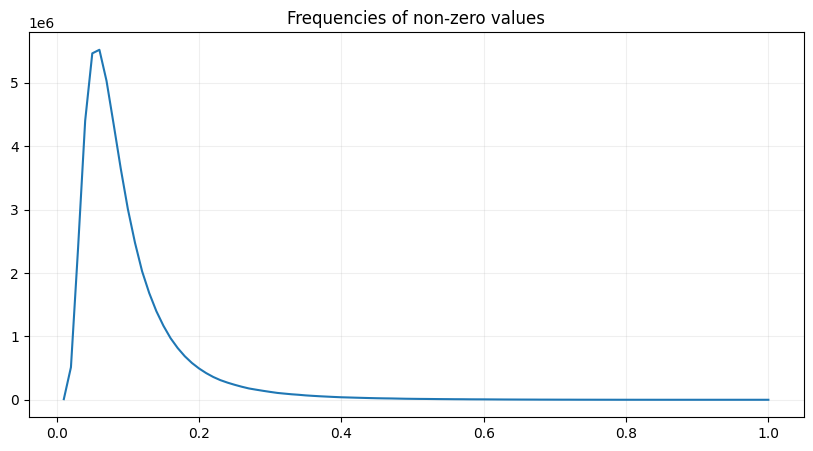

In [39]:
plt.subplots(figsize=(10, 5))
plt.plot(x_plot, freq)
plt.grid(alpha=0.2)
plt.title("Frequencies of non-zero values")
# plt.xticks(x_plot)

In [40]:
def freq_small(array):
    array = array[np.nonzero(array)]
    array = array[array <= 0.2]
    array_ = array*1000
    return np.bincount(array_.astype(int).flatten(), minlength=200).reshape(1, 200)

freqy_small = da.map_blocks(freq_small, X_dense, dtype="float64")

In [41]:
%%time
smally = freqy_small.compute()

CPU times: user 7.02 s, sys: 874 ms, total: 7.89 s
Wall time: 3min 25s


Text(0.5, 1.0, 'Frequencies of non-zero values between 0 and 0.2')

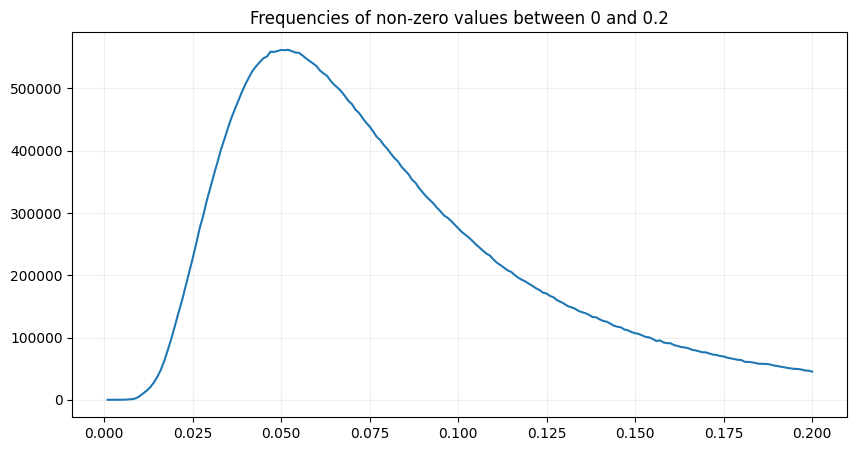

In [42]:
freq_small = np.sum(smally, axis=0)
x_mini = list(map(lambda i: i/1000, range(1, 201)))
plt.subplots(figsize=(10, 5))
plt.plot(x_mini, freq_small)
plt.grid(alpha=0.2)
plt.title("Frequencies of non-zero values between 0 and 0.2")

Furthermore, we have verified the aforementioned normalization of each sample by calculating the norm of each article. As expected, these norms cluster around a value close to 1.

In [15]:
zeros = np.zeros((1,47236))
def distance_zero(el):
        return np.sum((el[:, np.newaxis] - zeros) ** 2, axis=2).reshape(el.shape[0], zeros.shape[0])
norm = da.map_blocks(distance_zero, X_dense, dtype="float64")

In [16]:
%%time
norms = norm.compute()

CPU times: user 1.86 s, sys: 636 ms, total: 2.5 s
Wall time: 23.9 s


In [17]:
np.max(norms), np.min(norms)

(1.0000000000000047, 0.9999999999999948)

### Silhouette analysis

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluste r.

<img src="results/silhouette_true_labels2.png" alt="Silhouette plot">

### Metrics

As has been already stated, our goal emphasizes Dask framework optimization by monitoring execution time and memory usage rather than clustering accuracy. Computation times are therefore recorded, but most importantly Dask provides a useful diagnostic tool in the form of Dashboard, extensively used in this work. In particular all the major computations can be analysed offline by capturing the live dashboard with `performance_report` and are thus integral part of this project's results.

We will briefly show the striking difference between the dashboard view of a poorly suited task (The silhouette plot) and a neat execution of an optimezed task(1 iteration of the algorithm).

<img src="images/Terrible_silhouette_dashboard_vs_Good_iteration_b1000_ct1000.png" alt="Silhouette plot"> 

Each line-block in these task streams represents a thread. A few things are noteworthy: the mean time of inactivity given by the white horizontal spaces, the loading patterns, in red, such as frequency and the tasks run in parallel (vertically) with the loading. A clever chunk size selection coupled with suitable tasks and functions (e.g. numpy operations) are key to reach the full potential of the available resources. Additionally, erred task, if present, will be visible in black, while memory spilled to disk would be shown in orange.
<br>
<br>
Looking at `performance_report` summary, it is possible to quantify how much the silouhette plot's transfer time is greater than the other one:

**Tasks Information**

|  | number of tasks | compute time | deserialize time | transfer time |
| ---- | --------------- | ------------ | ---------------- | ------------- |
| silhouette plot | 35014 | 439.06 s | 219.31 ms | 544.89 s |
| 1 iteration Kmeans | 11115 | 429.36 s | 260.81 ms | 30.06 s


## Mini Batch Clustering

### Architecture and Motivations

Mini-batch K-Means is a variant of the traditional K-Means clustering algorithm tailored to address the demands of latency, scalability, and sparsity commonly encountered in user-facing web applications. 
<br> The primary goal of K-means algorithm is to partition a dataset into $k$ clusters. It operates iteratively on a dataset, denoted as $X$, comprising of $n$ examples, each having $m$ features. K-Means utilizes a set $C$ to represent cluster centers, with each center $c_j$ being a point in the same $m$-dimensional feature space ($\mathbb{R}^m$). The core objective function that Mini-batch K-Means aims to minimize is defined as follows:

$$
\min_{C} \sum_{x \in X} \left\|f(C, x) - x\right\|^2
$$

In this formula:

$C$ represents the set of cluster centers, where $\left|C\right| = k$.
$f(C, x)$ returns the nearest cluster center $c$ belonging to $C$ for a given example $x$, using the Euclidean distance $x$ represents an example within the dataset $X$.
<br><br>
Unlike the standard K-Means algorithm, in Mini-Batch K-Means, training samples are randomly selected during each iteration to create a minibatch of size $b$. For each sample in the minibatch, the objective function is applied using the current centroids. Subsequently, the assigned centroid is updated, taking into account both the sample and a learning rate that is inversely proportional to the number of points already assigned to that cluster.
<br><br>
**Architecture**
The pseudocode of the algorithm is extracted from the original paper from D. Sculley, [(Sculley, D. (2010). Web-scale k-means clustering)](https://dl.acm.org/doi/10.1145/1772690.1772862): 
<img src="images/minibatchkmeans.png" alt="MiniBatch Kmeans" width="500" height="500"> 

**Inertia**
In K-means clustering evaluation, we use a metric called 'inertia,' which is defined as follows:
$$
\sum_{j=0}^k\sum_{i=0}^n min_{c_j \in C}{\left\|x_i - c_j\right\|^2}
$$
Inertia measures how internally cohesive clusters are in a K-means solution. Specifically, it calculates the sum of squared distances between data points (represented by $x_i$ and their respective predicted cluster centers $c_j$).
A lower inertia value indicates that the data points within clusters are closer to their cluster centers, suggesting well-defined and tightly grouped clusters. In contrast, a higher inertia value suggests that clusters are more spread out, which can indicate less coherent or poorly separated clusters.

**Minibatch Kmeans initialization**
Initialization is a crucial step in the K-means algorithm. When dealing with data that is not uniformly distributed, using a classical uniform distribution can lead to unbalanced clustering. In our case, the majority of the data points are close to $\sim 0.05$, as showed in "dataset exploration" section, then one random cluster initialized using a uniform distribution might end up encompassing most of the data, leaving the other three clusters empty.
<br>
Instead, we have chosen to follow the recommendation from the paper by Sculley and initialize the clusters using randomly selected samples from the data. Given that the majority of these samples fall within a similar range of values, it is reasonable to assume that the random initialization will not result in one of the four clusters containing uncommon values.
<br>
This approach not only ensures more balanced clusters but also accelerates the initialization process, which now takes only a few seconds.

**`Mini_KMeans` class**
As previously introduced, we trained the algorithm using various configurations of $(workers, threads, batch size, chunk size)$ to identify the optimal combination in terms of time and efficiency for cluster performance analysis. To facilitate this, our `Mini_KMeans` class and fit mode offer the following parameters:

* `n_clusters`, which represents $k$, the number of clusters into which we want to divide our dataset. Due to assumptions made during preprocessing, this value is fixed at 4.
* `threshold`, which signifies the minimum difference between the clusters of two consecutive iterations necessary to halt training before reaching the maximum number of iterations.
* `max_iter`, representing the maximum number of iterations.
* `batch_size`, indicating the chosen minibatch size for the configuration.
* `rechunk`, specifying the rechunking applied to the minibatch after its creation. When it is set to `"auto"`, Dask is allowed to perform its automathic rechunk, that for an original dataset with `chunksize=400` is equal to 355.
* `user_centroids`, a useful parameter allowing the loading of specific centers as initialization centers, particularly useful when training is interrupted due to cluster problems.
* `v_user`, similar to user_centroids, it loads a given vector of points (v) for restarting training using a custom learning rate.
* `verbose = False`, enabling this parameter allows for the printing of the current iteration progress.
* `v_factor = 0.75`: setting the maximum percentage of iteration points (`max_iter * batch_size`) that can be assigned to a single center. This factor was introduced to prevent a random center near zero from absorbing all training points.

After each iteration, the total inertia and the iteration time are provided.
<br><br>
To ensure a coherent comparison of results, we selected a fixed seed for training the algorithm.

In [19]:
# KMEANS FINAL VERSION
import time
class Mini_KMeans:
    def __init__(self, n_clusters=4, threshold=1e-3, max_iter=10000, batch_size=10):
        super(Mini_KMeans, self).__init__()
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.threshold = threshold
    def fit(self, X_train, rechunk=False, user_centroids=None, verbose=False, v_factor = 0.75, v_user = None):
        if user_centroids is not None:
            self.centroids = user_centroids
        else:
            start_time = time.time()
            
            init_indx = np.sort(np.random.choice(X_train.shape[0], size=self.n_clusters, replace=False))
            self.centroids = X_train[init_indx,:].compute()
            print(f"done with init, time: {(time.time() - start_time):.{2}f} s")

        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        # collect the number of points per cluster in order to calculate the learning rate
        if v_user is not None:
            v = v_user
        else:
            v = np.zeros(self.n_clusters)
        max_v = v_factor * self.batch_size * self.max_iter  #to check if one center gets too many counts, k is the maximum fraction of all possible counts
        trace_classes = np.zeros(X_train.shape[0])
        if verbose: print("starting while cycle")
        inertia_diff = self.threshold + 1
        times = []
        inertias = []
        while iteration < self.max_iter and inertia_diff > self.threshold:
            start_time = time.time()
            
            # parallelize this section with dask
            indx = np.sort(np.random.choice(X_train.shape[0], size=self.batch_size, replace=False))
            # this part is necessary to optimize computation and don't have problems with further functions

            # choose between auto rechunk, a custom number of chunks or no rechunk
            if rechunk == 'auto':
                minibatch = X_train[indx,:].rechunk(chunks="auto")
                # print(minibatch.chunksize)
                
            elif rechunk != False:
                minibatch = X_train[indx,:].rechunk((rechunk, X_train.shape[1]))    #rechunk here is number of rows

            else:
                minibatch = X_train[indx,:]
                
            dists = da.sum((minibatch[:, np.newaxis] - self.centroids) ** 2, axis=2)
            centroid_idx = da.argmin(dists, axis=1)
            inertia = (dists.ravel()[centroid_idx + da.arange(0, self.batch_size*self.n_clusters, self.n_clusters)]).sum()
            
            # end of parallelized section
            
            # compute all togheter to save a lot of time and parallelize everything
            # if the minibatch is small enough, save it in memory
            mini_size = 5000
            
            if self.batch_size <= mini_size:
                centroid_idx, inertia, minibatch_t = compute(centroid_idx, inertia, minibatch)
            else:
                centroid_idx, inertia, minibatch_t = compute(centroid_idx, inertia, minibatch[:mini_size,:])

            inertias.append(inertia)
            client.cancel(dists)
            del dists

            if iteration > 0: inertia_diff = np.abs(inertias[iteration-1] - inertia)
            
            i = 0
            if verbose: print("starting for cycle")

            for i in range(self.batch_size):
                if v[centroid_idx[i]] >= max_v:
                    pass
                else:
                    if (self.batch_size > mini_size) and (i % mini_size == 0) and (i > 0):
                        client.cancel(minibatch_t)
                        del minibatch_t
                        if (self.batch_size - i) < mini_size:
                            minibatch_t = minibatch[i:,:].compute()
                            print(f"Compute progress: {i // mini_size + 1}/{self.batch_size//mini_size}"+" "*50, end="\r", flush=True)
                        else:
                            minibatch_t = minibatch[i:i+mini_size,:].compute()
                            print(f"Compute progress: {i // mini_size + 1}/{self.batch_size//mini_size}"+" "*50, end="\r", flush=True)
                    v[centroid_idx[i]] += 1
                    lr = 1/(v[centroid_idx[i]])
                    self.centroids[centroid_idx[i]] = (1 - lr)*self.centroids[centroid_idx[i]] + lr*minibatch_t[i%mini_size]
                    trace_classes[indx[i]] = int(centroid_idx[i])

            # free workers memory
            client.cancel(minibatch_t)
            del minibatch_t

            t = time.time() - start_time
            times.append(t)

            print(f"This iteration took {t:.{2}f} s")
            
            iteration += 1
            if iteration%1 == 0:
                print(f"Progress: {iteration}/{self.max_iter}, inertia: {inertia:.{3}f}"+" "*50)#, end="\r", flush=True)

            # save centroids every iteration
            ftype = "centr_temp"
            np.savez("results/{}".format(ftype), class_centers=self.centroids, v=v)

            #free workers memory
            client.cancel(inertia)
            client.cancel(centroid_idx)
            del inertia, centroid_idx    
            
        print(f"The process required {iteration} iterations."+" "*50)
        print(f"average while cycle computation time: {np.mean(times):.{2}f} s")
        print(f"final inertia: {inertias[-1]:.{3}f}")
        return self.centroids, trace_classes, inertias, times
    def predict(self, X, class_centers, plot = False, save_plot_name=False):
    
        starting_time = timer()
    
        dists_list = []
        for i in range(len(class_centers)):
            dists_list.append(da.sum((X - class_centers[i]) ** 2, axis=1).rechunk(-1))
    
        dists = da.asarray(dists_list).rechunk((X.shape[0],-1))
        centroid_idx = da.argmin(dists, axis=0)
        inertia = (dists.ravel()[centroid_idx + da.arange(0, X.shape[0]*self.n_clusters, self.n_clusters)]).sum()
    
        centroid_idx, inertia = compute(centroid_idx, inertia)
        
        ending_time = timer()

        # silhouette plot
        if (plot):
            import matplotlib.cm as cm
            import matplotlib.pyplot as plt
            from sklearn.metrics import silhouette_samples, silhouette_score
            
            indx = np.random.choice(X.shape[0], size=5000, replace=False)
            minibatch = X[indx,:]
            silhouette_avg=silhouette_score(minibatch,centroid_idx[indx])
            print(f"The silhouette average is {silhouette_avg}.")
            sample_silhouette_values = silhouette_samples(minibatch, centroid_idx[indx])
            
            fig, ax1 = plt.subplots()
            fig.set_size_inches(12, 5)
            ax1.set_xlim([-0.035, 0.035])
            ax1.set_ylim([0, len(minibatch) + (4 + 1) * 20])
            y_lower = 10
            for i in range(4):
                ith_cluster_silhouette_values = sample_silhouette_values[centroid_idx[indx] == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / 4)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )
            
                ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10  
                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")   # average
                ax1.set_yticks([])  
                ax1.set_xticks([-0.035,-0.025,-0.015,-0.005, 0,0.005,0.015,0.025,0.035])
            ax1.text(silhouette_avg +0.0002, 900, "Average",color="red",rotation=270)
            plt.show()
            if (not save_plot_name==False):
                plt.savefig("results/{}.png".format(save_plot_name), dpi=300)
        
        return centroid_idx, inertia, ending_time - starting_time

[![DAG example Image](dask_graph_parallel.png)](dask_graph_parallel.png)

### Toy Example

In this section, we provide an toy example of training with the following parameters: `n_workers=3`, `n_threads=4`, `batch_size=1000`, and `rechunk="auto"`. In addition, a `performance_report` toy is returned.

In [20]:
%%time
seed = 18092023 #144
np.random.seed(seed)
da.random.seed(seed)
# Fit centroids to dataset and save dashboard report
with performance_report(filename="results/toy_example.html"):
    kmeans = Mini_KMeans(n_clusters=4, threshold=1e-5, max_iter=50, batch_size=1000)
    class_centers, classes, inertias, fit_time = kmeans.fit(X_dense, rechunk="auto", user_centroids=None, v_user=None) # fit time is in seconds

done with init, time: 3.60 s
This iteration took 9.34 s
Progress: 1/50, inertia: 1883.513                                                  
This iteration took 10.94 s
Progress: 2/50, inertia: 975.866                                                  
This iteration took 8.91 s
Progress: 3/50, inertia: 972.192                                                  
This iteration took 11.71 s
Progress: 4/50, inertia: 970.180                                                  
This iteration took 9.38 s
Progress: 5/50, inertia: 970.144                                                  
This iteration took 9.68 s
Progress: 6/50, inertia: 968.587                                                  
This iteration took 8.93 s
Progress: 7/50, inertia: 969.121                                                  
This iteration took 8.84 s
Progress: 8/50, inertia: 968.385                                                  
This iteration took 11.96 s
Progress: 9/50, inertia: 969.551                            

As mentioned, we introduced the possibility to save the temporary centroids and v vectors, in order to prevent data loss due to cluster failure. In the following cell we provide an example reloading data.

In [ ]:
# load old centers

ftype = "centr_temp" # string to add in the file name

file = "results/{}.npz".format(ftype)

data = np.load(file) # data is a dictionary with all the variables

# load parameters into variables
locals().update(data)
centroids = data['class_centers']
v_saved = data['v']

After the training, the `predict` method from the class is employed to assign to each point of the dataset a class.
The function offer the following parameters:
* `class_centers`, in order to upload the center predicted by the train
* `plot`, which provide the silhouette plot of the predicted labels
* `save_plot_name=False`, when enabled, it allows to save the silhouette plot.

The silhouette average is 0.007387885582450693.


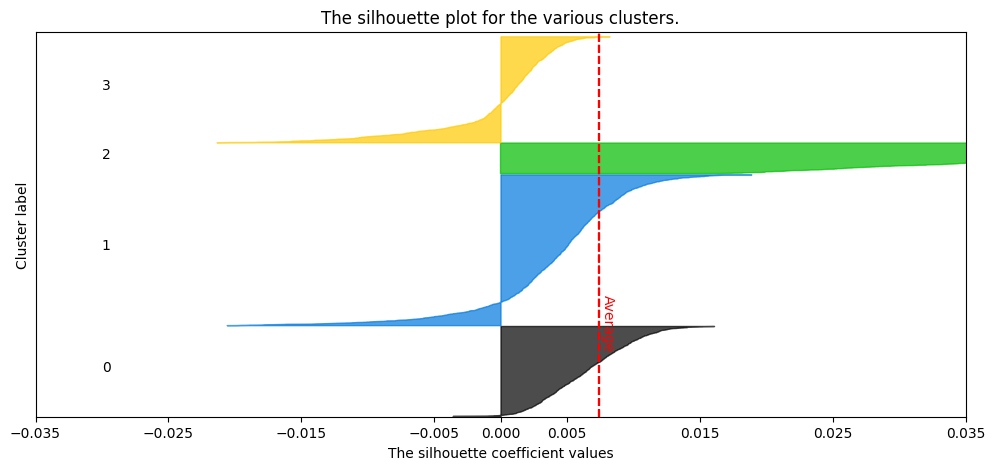

CPU times: user 57.7 s, sys: 9.56 s, total: 1min 7s
Wall time: 1min 56s


In [21]:
%%time
labels, final_inertia, pred_time = kmeans.predict(X_dense, class_centers, plot=True)

As can be seen from the silhouette plot of the predicted labels, even with the weak hypothesis driving our preprocessing, we are still able to achieve a similar structure compared to the true labels plot. Despite it not being our main goal, we will in fact show in the following sections that the accordance reached with the correct labels is close to 50%.

In [22]:
print(final_inertia/len(true_lab))

0.9989735631425825


The result of this example are reported in the following plots:

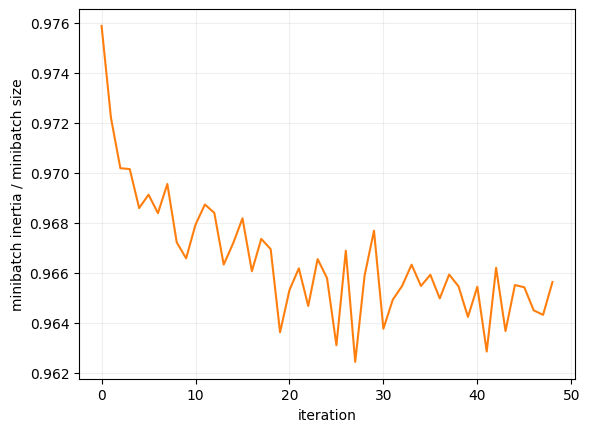

In [23]:
plt.plot(np.array(inertias[1:])/1000, color="C1")
plt.xlabel("iteration")
plt.ylabel("minibatch inertia / minibatch size")
# plt.hlines(final_inertia/X_dense.shape[0], 0, len(inertias))
plt.grid(alpha=0.2)
plt.show()

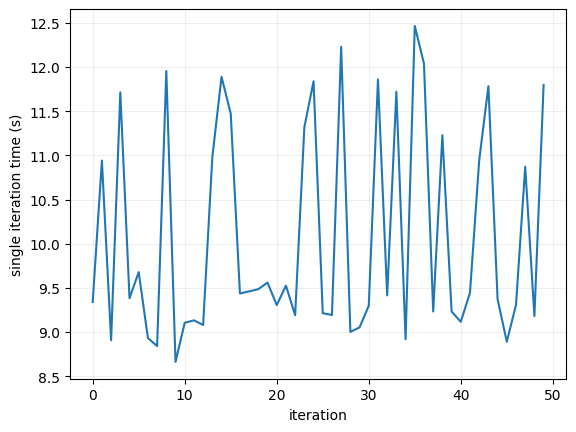

In [24]:
plt.plot(fit_time)
plt.xlabel("iteration")
plt.ylabel("single iteration time (s)")
plt.grid(alpha=0.2)
plt.show()

In [25]:
freq_pred = np.unique(labels, return_counts=True)[1] / labels.shape[0]
freq_true = np.unique(true_lab, return_counts=True)[1] / true_lab.shape[0]

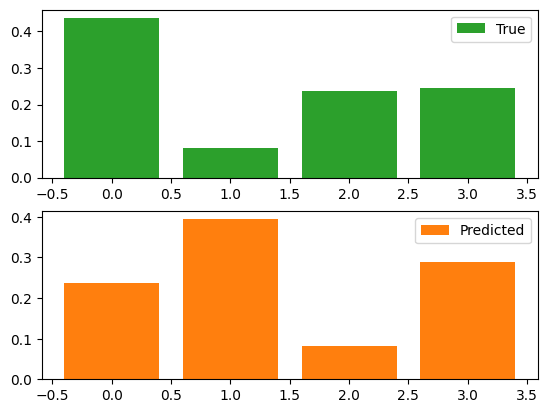

In [26]:
fig, ax = plt.subplots(2)
ax[0].bar(np.arange(4), freq_true, label="True", color="C2")
ax[1].bar(np.arange(4), freq_pred, label="Predicted", color="C1")
ax[0].legend()
ax[1].legend()
plt.show()

The effective correlation between the "true" (theoretical) labels we calculated in the prepocessing and the predicted labels are calculated using the function `adjusted_rand_score` from scikit-learn metrics. It allows to evaluate whether two clusters represent the same configuration regardless the order of the labels.

In [27]:
from sklearn.metrics.cluster import adjusted_rand_score
print(f"the correlation is of {np.around(adjusted_rand_score(true_lab, labels)*100,2)}%")

the correlation is of 45.36%


In [28]:
# compare with random labels
print(f"the correlation is of {np.around(adjusted_rand_score(np.random.randint(0, 4, size=len(labels)), labels), 4)*100}%")

the correlation is of 0.0%


In order to compare the results, we have saved the results from each configuration into a npz file. To each of them a specific name has been assigned indicating with $w$ the number of workers employed, $t$ the number of thresholds, $b$ the minibatch size, $cp$ the rechunk applied to the whole dataset and $ct$ the rechunk applied to the minibatch.

In [29]:
# save results in a npz file
ftype = "w3t3b1000cp400ct1000_toy"

np.savez("results/{}".format(ftype), class_centers=class_centers, inertias=inertias, fit_time=fit_time, labels=labels, final_inertia=final_inertia, pred_time=pred_time)

## Results

### Minibatch size graphs

**Results for testing different batch sizes** <br>
parameters: <br>
chunk size minibatch: "auto" (355), chunk size dataset: 400, n_workers: 3, n_threads: 4 <br>
The number of iterations for the various tests were chosen in order to have a total number of data points analyzed by the algorithm similar to the length of the dataset: <br>
n iterations * batch_size $\sim len(dataset) \sim 700k$ with threshold: 1e-5<br>



| file name | batch size | n iter | fit time | inertia fit/batch_size | inertia predict/len(dataset) | adjusted score | notes |
| --------- | ---------- | ------ | -------- | ----------- | --------------- | -------------- | --------- |
| **w3t4b50cp400ct50** | 50 |  1000 | 1h | 0.9917 | 1.1165 | 0.23% | Few iterations performed due to excessively long execution times
| **w3t4b500cp400ct355** | 500 |  1400 | 3h | 0.981 | 1.0192 | 43.52% | cluster died after 400 iters
| **w3t4b1000cp400ct355** | 1000 | 700 | 2h | 0.9815 | 1.0067 | 52.22% |
| **w3t4b5000cp400ct355** | 5000 | 140 | 49 min | 0.9810  |1.0031  | 47.4%   |
| **w3t4b10000cp400ct355** | 10000 | 70 | 42 min | 0.9804  |1.0106  |49.24%  |cluster died after 55 iters 
| **w3t4b50000cp400ct355** | 50000 | 14 | 23 min | 0.9809 | 1.0069 | 48.36% | cluster died 2 times
| **w3t4b100000cp400ct355** | 100000 | 7 | 30 min | 0.9810 | 1.0063 | 48.19% | cluster died almost after every iteration

In [30]:
# load old data
x = [50, 500, 1000, 5000, 10000, 50000, 100000]
fit_inertia = []
time_per_iter = []
fit_predict = []
adjust_score = []
for i, el in enumerate(x):
    ftype = el # string to add in the file name
    if i == 0:
        file = "results/w3t4b{}cp400ct50.npz".format(ftype)
        data = np.load(file) # data is a dictionary with all the variables
        locals().update(data)
        fit_inertia.append(data["inertias"][-1]/el)
        time_per_iter.append(data["fit_time"].mean())
        fit_predict.append(data["final_inertia"]/len(true_labels))
        adjust_score.append(np.around(adjusted_rand_score(true_lab, data["labels"])*100,2))
    else:
        file = "results/w3t4b{}cp400ct355.npz".format(ftype)
        data = np.load(file) # data is a dictionary with all the variables
        locals().update(data)
        fit_inertia.append(data["inertias"][-1]/el)
        time_per_iter.append(data["fit_time"].mean())
        fit_predict.append(data["final_inertia"]/len(true_labels))
        adjust_score.append(np.around(adjusted_rand_score(true_lab, data["labels"])*100,2))

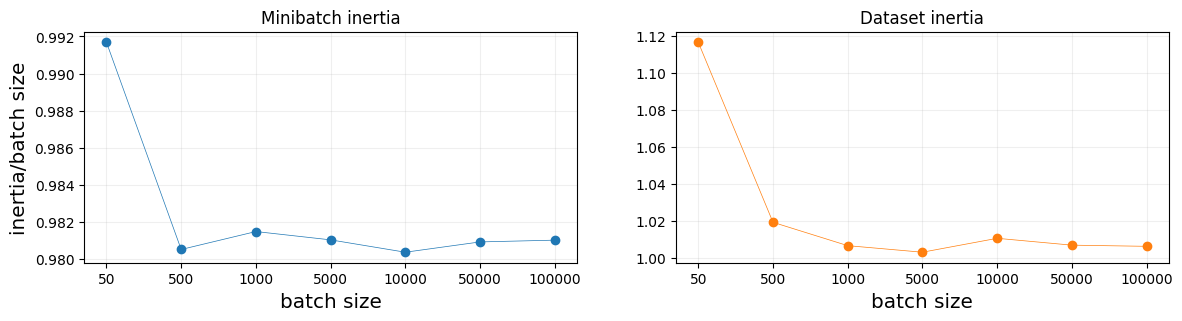

In [31]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14, 3))

x_plot = ["50", "500", "1000", "5000", "10000", "50000", "100000"]

ax[0].plot(x_plot, fit_inertia, marker="o", c="C0", linewidth=0.5)
ax[1].plot(x_plot, fit_predict, marker="o", c="C1", linewidth=0.5)
ax[0].set_xlabel("batch size", fontsize="x-large")
ax[1].set_xlabel("batch size", fontsize="x-large")
ax[0].set_ylabel("inertia/batch size", fontsize="x-large")
ax[0].set_title("Minibatch inertia")
ax[1].set_title("Dataset inertia")
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
plt.show()

Except for the 50-rows minibatch, which would require a much higher number of iterations (and hours of execution); for the other cases, having done a number of iterations such as to keep the product `n_iterations` * `batch_size` almost constant, the inertia value is similar.

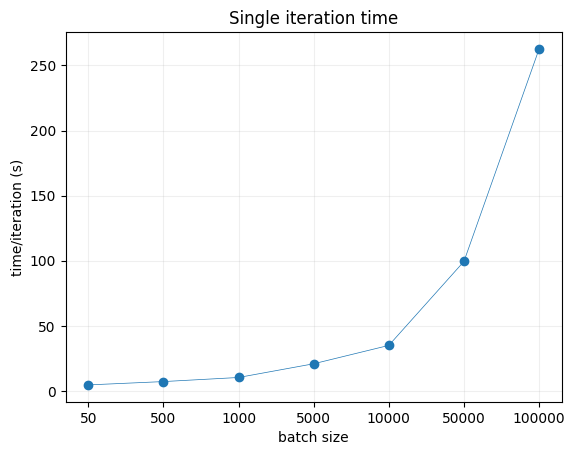

In [32]:
plt.plot(x_plot, time_per_iter, marker="o", c="C0", linewidth=0.5)
plt.xlabel("batch size")
plt.ylabel("time/iteration (s)")
plt.title("Single iteration time")
plt.grid(alpha=0.2)

As expected, the average execution time per iteration rises with the increase in batch size.
Furthermore, for batches ranging from 10,000 and above the time increases further due to the fact that we cannot do a single computation on the entire minibatch but must first divide it into smaller parts.


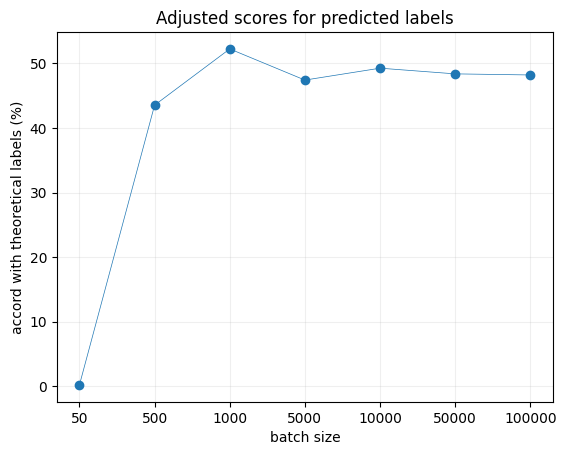

In [33]:
plt.plot(x_plot, adjust_score, marker="o", c="C0", linewidth=0.5)
plt.xlabel("batch size")
plt.ylabel("accord with theoretical labels (%)")
plt.title("Adjusted scores for predicted labels")
plt.grid(alpha=0.2)

The adjusted score also shows similar values for the various runs (except for the 50 rows minibatch).

Considering the total execution time, the reliability of the runs performed and the inertia and score parameters, we can state that the values in the middle for the minibatch size (1'000, 5'000 and 10'000 rows) are the best. This is because with smaller minibatches too many iterations are required, and therefore very long execution times are needed to obtain good results. For very large minibatches, however, the cluster struggles to manage them and tends to die frequently, making the algorithm's reliability questionable.

### Minibatch and predict rechunk graphs

Now, we experiment with various minibatch rechunk values for the three configurations that performed the best in the prior tests.

**Results for testing different batch rechunks** <br>
parameters: <br>
chunk size dataset: 400, n_workers: 3, n_threads: 4 <br>
Same principle as the previous tests for choosing the number of iterations<br>

| file name | batch chunk size | batch size | n iter | fit time | inertia fit/batch_size | inertia predict/len(dataset) | adjusted score | notes |
| --------- |  ---- |---------- | ------ | -------- | ----------- | --------------- | -------------- | --------- |
| **w3t4b1000cp400ct50** | 50 | 1000 | 700 | 2h 5min | 0.9815 | 1.0067 | 52.22% |  |
| **w3t4b1000cp400ct355** | 355 | 1000 | 700 | 2h | 0.9815 | 1.0067 | 52.22% |  |
| **w3t4b1000cp400ct1000** | 1000 | 1000 | 700 | 2h 3min | 0.9815 | 1.0067 | 52.22% |  |
| **w3t4b5000cp400ct50** | 50 | 5000 | 140 | 65 min | 0.9803 | 1.0149 | 43.76% | cluster died 2 times |
| **w3t4b5000cp400ct355** | 355 | 5000 | 140 | 49 min | 0.9810  | 1.0031  | 47.4%   |  |
| **w3t4b5000cp400ct1000** | 1000 | 5000 | 140 | 47 min |  0.9809  | 1.0129  | 47.22% | cluster died after 103 iter |
| **w3t4b10000cp400ct50** | 50 | 10000 | 70 | 65 min | 0.9801  | 1.0123 | 42.71% | cluster died every 10 iterations |
| **w3t4b10000cp400ct355** | 355 | 10000 | 70 | 42 min | 0.9804  | 1.0106 | 49.24%  | cluster died after 55 iters |
| **w3t4b10000cp400ct1000** | 1000 | 10000 | 70 | 42 min | 0.9812 | 1.0008 | 45.86% | crushed after 30 iterations |

In [34]:
# load old data
ct_list = [50, 355, 1000]
b_list = [1000, 5000, 10000]

fit_inertia = []
time_per_iter = []
fit_predict = []
adjust_score = []
x_plot = []

for b in b_list:
    for ct in ct_list:
        file = "results/w3t4b{}cp400ct{}.npz".format(b, ct)
        data = np.load(file) # data is a dictionary with all the variables
        locals().update(data)
        fit_inertia.append(data["inertias"][-1]/b)
        time_per_iter.append(data["fit_time"].mean())
        fit_predict.append(data["final_inertia"]/len(true_labels))
        adjust_score.append(np.around(adjusted_rand_score(true_lab, data["labels"])*100,2))
        x_plot.append(f"{b}, {ct}")

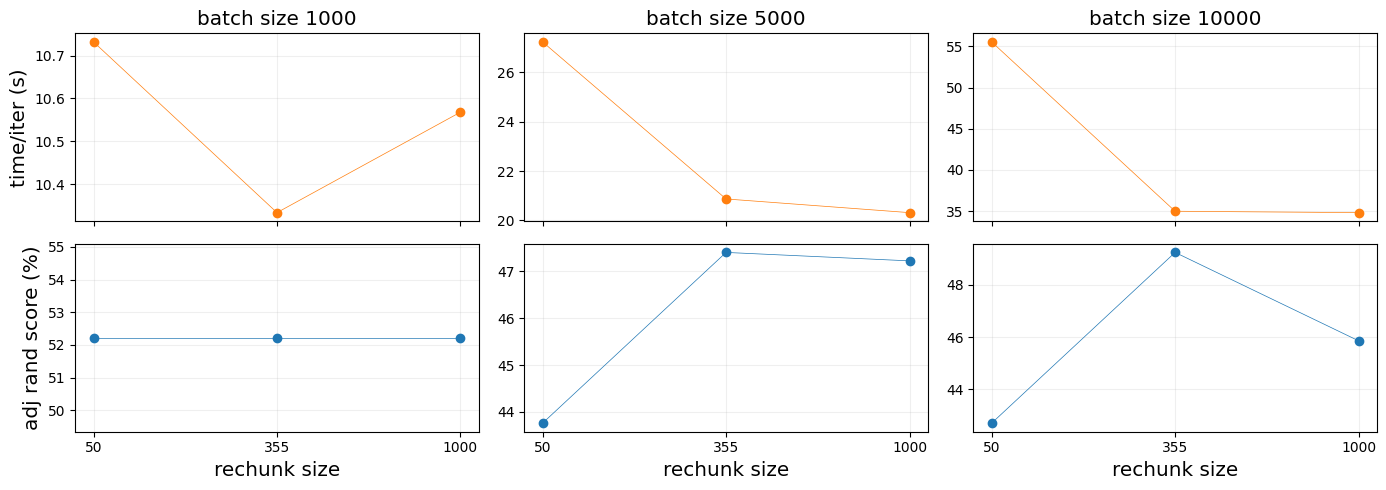

In [35]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(14, 5))

ct_char = [f"{c}" for c in ct_list]

for i in range(3):
    ax[0][i].plot(ct_char, time_per_iter[3*i:3*i+3], marker="o", c="C1", linewidth=0.5)
    ax[1][i].plot(ct_char, adjust_score[3*i:3*i+3], marker="o", c="C0", linewidth=0.5)
    ax[1][i].set_xlabel("rechunk size", fontsize="x-large")
    ax[0][i].set_title(f"batch size {b_list[i]}", fontsize="x-large")
    ax[0][i].grid(alpha=0.2)
    ax[1][i].grid(alpha=0.2)
    
ax[0][0].set_ylabel("time/iter (s)", fontsize="x-large")
ax[1][0].set_ylabel("adj rand score (%)", fontsize="x-large")
    
plt.tight_layout()
plt.show()

Dask dashboard for an iteration of the algorithm with a 5000 rows minibatch with a rechunk of 50 (left) and 1000 (right) rows:

<img src="images/rechunk_50_vs_1000.png" alt="rechunk">

Looking at the times and scores we notice a clear improvement going from a small rechunk of 50 rows to a larger one, while between those of 355 and 1000 rows there are no huge differences. From this we can deduce that a rechunk that creates too many small partitions is inefficient.
Looking at the dask dashboard we can see that with the rechunk of 50 rows there are many more data transfers between workers which cause slowdowns compared to the 1000 rows rechunk.
Finally, if we compare the 355 and 1000 rechunks we see that, in terms of execution times, the 355 one is better for a smaller minibatch (1000) while for larger minibatches they obtain very similar times.

A parallel inspection can now be carried on the possible rechunk sizes for the predict. Since it must act on all the data to make the final label predictions, the rechunk sizes involved are applied to the whole dataset. 

**Results for testing different dataset chunk sizes** <br>
parameters: <br>
batch chunk size: 355, n_workers: 3, n_threads: 4 <br>
Same principle as the previous tests for choosing the number of iterations<br>

| file name | pred chunk size | batch size | pred time  | notes |
| --------- |  ---- |---------- |  -------- |  --------- |
| **w3t4b1000cp400ct355_PRED** | 400 | 1000 | 1 min 4s |   |
| **w3t4b1000cp200ct355_PRED** | 200 | 1000 | 1 min 26s  |   |
| **w3t4b1000cp800ct355_PRED** | 800 | 1000 | 2 min 37s | limit: dashboard shows one worker left multiple times + memory spilled to disk   |
| **w3t4b1000cp600ct355_PRED** | 600 | 1000 | 2 min 33s  | worker left ++  | 
| **w3t4b1000cp50ct355_PRED** | 50 | 1000 |7min 29s |  worker left ++ | 

In [36]:
# load old data
cp_list = [50, 200, 400, 600, 800]


pred_time_l = []
x_plot = []


for _ in cp_list:
    file = "results/w3t4b1000cp{}ct355_PRED.npz".format(_)
    data = np.load(file) # data is a dictionary with all the variables
    locals().update(data)
    pred_time_l.append(data["pred_time"])
    x_plot.append(f"{_}")

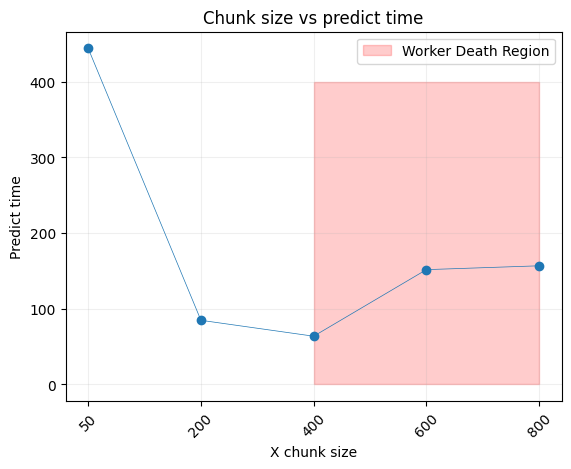

In [37]:
plt.plot(x_plot, pred_time_l, marker="o", c="C0", linewidth=0.5)
plt.xlabel("X chunk size")
plt.ylabel("Predict time")
plt.title("Chunk size vs predict time")
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
worker_death_region = [int(x) >= 400 for x in x_plot]
plt.fill_between(x_plot, 400, where=worker_death_region, color='red', alpha=0.2, label='Worker Death Region')

# Add a legend to explain the shaded region
plt.legend()
plt.show()

Once again the influence of the chunksize, this time in regards to the entire dataset entering in the predict, is impossible to overstate. Above a certain optimal threshold the workers encounter multiple sudden deaths because the required memry allocation is to great. On the other hand tiny chunksizes are detrimental to performance since the schedular overhead becomes a prominent issue, coupled with inefficient data transfering.

Below lies a graphical examplification of the discussed paradigma between the extreme ends: lowest (practically) seizable chunksize for the dataset of 50 and the optimal value of 400. This chart covers aproximately 1 min which is enough for total completition of the latter, but only 1/7 of the former. In particular the extract shows 2 separate regions with different issues in the task stream with chunksize of 50 (LEFT): the first region involves getting the item, that is the whole dataset array, in small chunks and thus is overhead dominated, whereas in the second region the actual computation starts, albeit with strong inefficience visible by the frequent overlapping (red) data transfers. 

<img src="images/cp50_PRED_vs_cp400.png" alt="Silhouette plot">

### Number of workers graphs

**results for testing different numbers of workers and threads** <br>
parameters: <br>
chunk size dataset: 400, minibatch size: 1000, minibatch rechunk: 1000
Reduced number of iterations since we are only interested in the average times of a single iteration<br>

| file name | nworkers | nthreads | n iter | fit time | predict time | inertia fit/batch_size | inertia predict/len(dataset) | adjusted score | notes |
| --------- |  ---- |---------- | ------ | -------- | ----------- | --- | --------------- | -------------- | --------- |
| **w1t4b1000cp400ct1000** | 1 | 4 | 7 | 1min 43s | 2min 8s | 0.9843 | 0.9963 | 26.65% |  |
| **w2t4b1000cp400ct1000** | 2 | 4 | 7 | 1min 40s | 1min 38s | 0.9843 | 0.9963 | 26.65% |  |1min 24s
| **w3t2b1000cp400ct1000** | 3 | 1 | 7 | | | | | | unable to finish: cluster dies
| **w3t2b1000cp400ct1000** | 3 | 2 | 7 | 1min 30s | 1min 31s | 0.9843 | 0.9963 | 26.65%
| **w3t3b1000cp400ct1000** | 3 | 3 | 7 | 1min 16s | 1min 7s | 0.9843 | 0.9963 | 26.65%
| **w3t4b1000cp400ct1000_7iter** | 3 | 4 | 7 | 1min 18s | 1min 9s | 0.9843 | 0.9963 | 26.65% |  |
| **w6t4b1000cp400ct1000** | 6 | 4 | 7 | 1min 24s | 1min 6s | 0.9843 | 0.9963 | 26.65% |  |
| **w9t4b1000cp400ct1000** | 9 | 4 | 7 | 1min 43s | 1min 44s | 0.9843 | 0.9963 | 26.65% |  |

In [38]:
# load old data
w_list = [1, 2, 3, 6, 9]
extra_char = ["", "", "_7iter", "", ""]

time_per_iter_worker = []
x_plot = [f"{w}" for w in w_list]

for i, w in enumerate(w_list):
    file = "results/w{}t4b1000cp400ct1000{}.npz".format(w, extra_char[i])
    data = np.load(file) # data is a dictionary with all the variables
    locals().update(data)
    time_per_iter_worker.append(data["fit_time"].mean())

In [39]:
t_list = np.arange(2,5)
extra_char = ["", "", "_7iter"]

time_per_iter_th = []

for i, t in enumerate(t_list):
    file = "results/w3t{}b1000cp400ct1000{}.npz".format(t, extra_char[i])
    data = np.load(file) # data is a dictionary with all the variables
    locals().update(data)
    time_per_iter_th.append(data["fit_time"].mean())

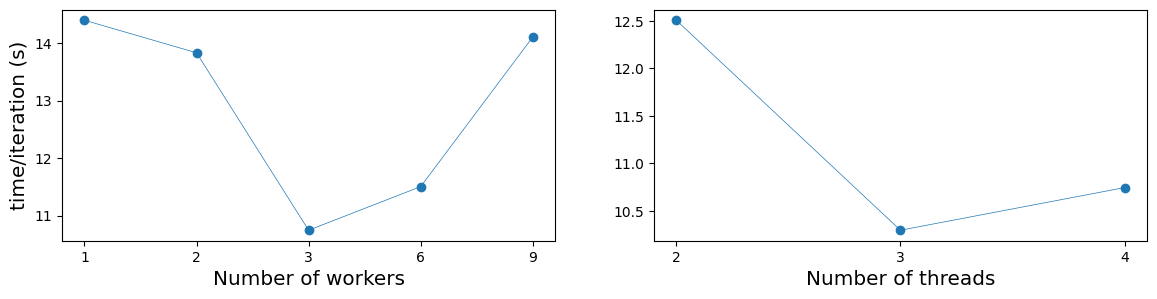

In [40]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14, 3))

t_char = [f"{t}" for t in t_list]

ax[0].plot(x_plot, time_per_iter_worker, marker="o", linewidth=0.5)
ax[1].plot(t_char, time_per_iter_th, marker="o", linewidth=0.5)
ax[0].set_xlabel("Number of workers", fontsize="x-large")
ax[1].set_xlabel("Number of threads", fontsize="x-large")
ax[0].set_ylabel("time/iteration (s)", fontsize="x-large")
plt.show()

Dask dashboard for an iteration of the algorithm with a 1000 rows minibatch with 1, 2, 3, 6 and 9 workers:

<img src="images/nworkers.png" alt="rechunk">

Comparing the times as the number of workers varies, we notice that the best configuration is the one with 3 workers.
This is because, as can also be seen from the dashboards, by increasing the number of workers we have an advantage given by the parallelization of the tasks and a disadvantage given by the increase in the volume of data to be transferred.
In the configuration with 3 workers we find a balance between these 2 conditions while with 6 and 9 workers the transfer times slow everything down excessively, and we notice that many of the workers remain inactive throughout the initial part. Furthermore, it must be considered that resources are limited, so as the number of workers increases, each of them will have less resources at their disposal.

It is also interesting to see how execution times change when the number of threads per worker varies.
If the computations are mostly numeric in nature (for example NumPy computations) and release the *Global interpreter lock* (GIL) entirely then it is advisable to run dask worker processes with many threads. This reduces communication costs and generally simplifies deployment.
If the computations are mostly Python code and don’t release the GIL then it is advisable to run dask worker processes with one thread.

In our case we mainly work with numpy functions, so it is convenient to use a high number of threads, but since we also use Python code for cycles and lists in our algorithm, we still have limitations. The best times are in fact those with 3 threads per worker, followed by those with 4, while configurations with only 2 threads are the worst. Furthermore, the runs we tried with a single thread killed the cluster and failed to finish.

### Is the Euclidean Distance the best objective function for RCV1 dataset?

As mentioned earlier, our dataset comprises approximately $685k$ articles and around $47k$ features. Each feature has been normalized to a value within the range of $x \in [0,1]$, as it was derived from log TF-IDF using cosine normalization. Given this, it seems reasonable to consider evaluating the similarity between samples in a cluster using cosine similarity instead of the Euclidean distance. The formula for cosine similarity is as follows:

$$
similarity_j = max_{\{c\}} \frac{\sum_i^m X_{ij}*c_i}{\sqrt{\sum_i^m X_i^2}\cdot \sqrt{\sum_i^m c_i^2}}
$$
where $m$ represents the number of features, X is the j-esim article and c is the cluster that maximize the cosine similarity for the article. 
<br><br>
Here, $m$ represents the number of features, $X_j$ is the j-th article and $c$ is the cluster that maximizes the cosine similarity for the article.

The following class is almost identical to the MiniBatch K-means class, with this new distance metric implemented. Consequently, it introduces a new inertia measure, which is the squared sum of these similarities. In contrast to the previous inertia measure, which was optimized to be small, now a larger inertia indicates better results.

The objective of this final experiment is to evaluate whether it's possible to achieve similar or improved results using this more appropriate distance metric and to compare the outcomes with those obtained from classical MiniBatch K-means.

In [41]:
# KMEANS FINAL VERSION
import time
class Mini_KMeans_mod:
    def __init__(self, n_clusters=4, threshold=1e-3, max_iter=10000, batch_size=10):
        super(Mini_KMeans_mod, self).__init__()
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.threshold = threshold
    def fit(self, X_train, rechunk=False, user_centroids=None, v_user=None, verbose=False, v_factor = 0.75):
        if user_centroids is not None:
            self.centroids = user_centroids
        else:
            start_time = time.time()
            
            init_indx = np.sort(np.random.choice(X_train.shape[0], size=self.n_clusters, replace=False))
            self.centroids = X_train[init_indx,:].compute()
            print(f"done with init, time: {(time.time() - start_time):.{2}f} s")

        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        # collect the number of points per cluster in order to calculate the learning rate
        if v_user is not None:
            v = v_user
        else:
            v = np.zeros(self.n_clusters)
        v = np.zeros(self.n_clusters) # collect the number of points per cluster in order to calculate the learning rate
        max_v = v_factor * self.batch_size * self.max_iter  #to check if one center gets too many counts, k is the maximum fraction of all possible counts
        trace_classes = np.zeros(X_train.shape[0])
        if verbose: print("starting while cycle")
        inertia_diff = self.threshold + 1
        times = []
        inertias = []
        while iteration < self.max_iter and inertia_diff > self.threshold:
            start_time = time.time()
            
            # parallelize this section with dask
            indx = np.sort(np.random.choice(X_train.shape[0], size=self.batch_size, replace=False))
            # this part is necessary to optimize computation and don't have problems with further functions
            # the condition is also on the chunksize because if we rechunk a small chunk with a bigger size the cluster dies

            # choose between auto rechunk, a custom number of chunks or no rechunk
            if rechunk == 'auto':
                # this will raise a performaces warning since it doesn't do the rechunk immediatly
                minibatch = X_train[indx,:].rechunk(chunks="auto")
                # print(minibatch.chunksize)
                
            elif rechunk != False:
                minibatch = X_train[indx,:].rechunk((rechunk, X_train.shape[1]))    #rechunk here is number of rows

            else:
                minibatch = X_train[indx,:]
            
            # Compute dot products and norms
            dot_products = da.dot(minibatch, self.centroids.T)
            minibatch_norms = da.linalg.norm(minibatch, axis=1)
            centroid_norms = da.linalg.norm(self.centroids, axis=1)
            
            # Compute cosine similarities
            dists = dot_products / (minibatch_norms[:, None] * centroid_norms)
            
            # Find the index of the nearest centroid
            centroid_idx = da.argmax(dists, axis=1)
            
            # Compute inertia
            inertia = da.choose(centroid_idx, dot_products.T).sum()
            
            # end of parallelized section
            
            # compute all togheter to save a lot of time and parallelize everything
            # if the minibatch is small enough, save it in memory
            mini_size = 5000
            
            if self.batch_size <= mini_size:
                centroid_idx, inertia, minibatch_t = compute(centroid_idx, inertia, minibatch)
            else:
                centroid_idx, inertia, minibatch_t = compute(centroid_idx, inertia, minibatch[:mini_size,:])
            # centroid_idx, inertia, minibatch_t = compute(centroid_idx, inertia, minibatch)

            inertias.append(inertia)

            client.cancel(dists)
            del dists

            if iteration > 0: inertia_diff = np.abs(inertias[iteration-1] - inertia)
            
            i = 0
            if verbose: print("starting for cycle")

            for i in range(self.batch_size):
                if v[centroid_idx[i]] >= max_v:
                    pass
                else:
                    if (self.batch_size > mini_size) and (i % mini_size == 0) and (i > 0):
                        client.cancel(minibatch_t)
                        del minibatch_t
                        if (self.batch_size - i) < mini_size:
                            minibatch_t = minibatch[i:,:].compute()
                            print(f"Compute progress: {i // mini_size + 1}/{self.batch_size//mini_size}"+" "*50, end="\r", flush=True)
                        else:
                            minibatch_t = minibatch[i:i+mini_size,:].compute()
                            print(f"Compute progress: {i // mini_size + 1}/{self.batch_size//mini_size}"+" "*50, end="\r", flush=True)
                    v[centroid_idx[i]] += 1
                    lr = 1/(v[centroid_idx[i]])
                    self.centroids[centroid_idx[i]] = (1 - lr)*self.centroids[centroid_idx[i]] + lr*minibatch_t[i%mini_size]
                    trace_classes[indx[i]] = int(centroid_idx[i])

            # free workers memory
            client.cancel(minibatch_t)
            del minibatch_t

            t = time.time() - start_time
            times.append(t)

            print(f"This iteration took {t:.{2}f} s")
            
            iteration += 1
            if iteration%1 == 0:
                print(f"Progress: {iteration}/{self.max_iter}, inertia: {inertia:.{3}f}"+" "*50)#, end="\r", flush=True)

             # save centroids every iteration
            ftype = "centr_temp"
            np.savez("results/{}".format(ftype), class_centers=self.centroids, v=v)
            client.cancel(inertia)
            client.cancel(centroid_idx)
            del inertia, centroid_idx    
        print(f"The process required {iteration} iterations."+" "*50)
        print(f"average while cycle computation time: {np.mean(times):.{2}f} s")
        print(f"final inertia: {inertias[-1]:.{3}f}")
        return self.centroids, trace_classes, inertias, times
    def predict(self, X, class_centers, plot = False, true_lab = true_lab):
    
        starting_time = timer()
    
        dists_list = []
        for i in range(len(class_centers)):
            dists_list.append(da.sum((X - class_centers[i]) ** 2, axis=1).rechunk(-1))
            
        dists = da.asarray(dists_list).rechunk((X.shape[0],-1))
        centroid_idx = da.argmin(dists, axis=0)
        inertia = (da.sqrt(dists.ravel()[centroid_idx + da.arange(0, X.shape[0]*self.n_clusters, self.n_clusters)])).sum()
        
        # similarity 
        sim_list = []
        for i in range(len(class_centers)):
            sim_list.append(da.dot(X, class_centers[i]).rechunk(-1)/(da.linalg.norm(X, axis=1)*da.linalg.norm(class_centers[i])))

        sims = da.asarray(sim_list).rechunk((X.shape[0],-1))
        centroid_idx_sim = da.argmax(sims, axis=0)
        inertia_s = (da.sqrt(sims.ravel()[centroid_idx_sim + da.arange(0, X.shape[0]*self.n_clusters, self.n_clusters)])).sum()
        inertia_s_p = (da.sqrt(sims.ravel()[centroid_idx + da.arange(0, X.shape[0]*self.n_clusters, self.n_clusters)])).sum()


        centroid_idx, inertia, centroid_idx_sim, inertia_s, inertia_s_p = compute(centroid_idx, inertia, centroid_idx_sim, inertia_s, inertia_s_p)
        
        ending_time = timer()

        if (plot):
            import matplotlib.cm as cm
            import matplotlib.pyplot as plt
            from sklearn.metrics import silhouette_samples, silhouette_score
            
            indx = np.random.choice(X.shape[0], size=5000, replace=False)
            minibatch = X[indx,:]
            silhouette_avg=silhouette_score(minibatch,true_lab[indx])
            print(f"The silhouette average is {silhouette_avg}.")
            sample_silhouette_values = silhouette_samples(minibatch, true_lab[indx])
            
            fig, ax1 = plt.subplots()
            fig.set_size_inches(12, 5)
            ax1.set_xlim([-0.035, 0.035])
            ax1.set_ylim([0, len(minibatch) + (4 + 1) * 20])
            y_lower = 10
            for i in range(4):
                ith_cluster_silhouette_values = sample_silhouette_values[true_lab[indx] == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / 4)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )
            
                ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10  
                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")   # average
                ax1.set_yticks([])  
                ax1.set_xticks([-0.035,-0.025,-0.015,-0.005, 0,0.005,0.015,0.025,0.035])
            ax1.text(silhouette_avg +0.0002, 900, "Average",color="red",rotation=270)
            plt.show()
        
        return centroid_idx, inertia, centroid_idx_sim, inertia_s, inertia_s_p, ending_time - starting_time

To assess whether cosine similarity converges faster than the Euclidean distance, we conducted training using only approximately 50k points. This corresponds to 50 iterations with a batch size of 1000 points, which is roughly one-third of the number of points used with the Euclidean distance to achieve similar results.

In [42]:
%%time
seed = 18092023 #144
np.random.seed(seed)
da.random.seed(seed)
# Fit centroids to dataset and save dashboard report
with performance_report(filename="results/toy_newdist.html"): 
    kmeans2 = Mini_KMeans_mod(n_clusters=4, threshold=1e-5, max_iter=50, batch_size=1000) # 700 total
    class_centers, classes, inertias, fit_time = kmeans2.fit(X_dense, rechunk="auto", user_centroids=None) # fit time is in seconds

done with init, time: 1.84 s
This iteration took 11.24 s
Progress: 1/50, inertia: 58.243                                                  
This iteration took 8.82 s
Progress: 2/50, inertia: 27.024                                                  
This iteration took 11.27 s
Progress: 3/50, inertia: 28.841                                                  
This iteration took 9.26 s
Progress: 4/50, inertia: 30.180                                                  
This iteration took 11.71 s
Progress: 5/50, inertia: 30.382                                                  
This iteration took 8.86 s
Progress: 6/50, inertia: 31.488                                                  
This iteration took 8.15 s
Progress: 7/50, inertia: 31.220                                                  
This iteration took 11.76 s
Progress: 8/50, inertia: 31.696                                                  
This iteration took 9.02 s
Progress: 9/50, inertia: 30.976                                     

In [43]:
%%time
labels, final_inertia, labels_sim, inertia_sim, inertia_sim_p, pred_time = kmeans2.predict(X_dense, class_centers)

CPU times: user 6.64 s, sys: 514 ms, total: 7.15 s
Wall time: 2min 4s


In the next cell some correlations using `adjusted_rand_score` are provided. In the above predict two sets of labels are returned: the first one obtained through euclidean distance and the other through cosine similarity. The difference with all the previous trials lays in the fit method: only here cosine similarity is used to obtain class centers. 

In [44]:
print(f"the correlation between true labels and predicted labels, using euclidean distance, is of {np.around(adjusted_rand_score(true_lab, labels)*100,2)}%")
print(f"the correlation between true labels and predicted labels, using cosine similarity, is of {np.around(adjusted_rand_score(true_lab, labels_sim)*100,2)}%")
print(f"the correlation between the two predicted labels is of {np.around(adjusted_rand_score(labels, labels_sim)*100,2)}%")
print(inertia_sim_p/len(labels))
print(inertia_sim/len(labels))
final_inertia/len(labels)

the correlation between true labels and predicted labels, using euclidean distance, is of 46.2%
the correlation between true labels and predicted labels, using cosine similarity, is of 45.84%
the correlation between the two predicted labels is of 90.14%
0.3201768390670441
0.32017891207322957


0.9970808851197472

The results indicate that each individual iteration takes roughly the same amount of time as it does with the Euclidean distance. However, among the overall trials we explored, it's noteworthy that the cosine similarity-based approach achieves equivalent adjusted scores and inertia values (compared to the Euclidean distance) in fewer iterations. This suggests that using cosine similarity could be a promising technique to enhance the algorithm further. Additionally, the fact that the labels generated using this new distance metric align with those predicted using the Euclidean distance is a positive sign of its effectiveness.